In [1]:
import pandas as pd
import os 
import cv2
import shutil
import numpy as np

In [2]:
df = pd.read_excel('ODIR-5K/data.xlsx')

In [3]:
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


# 1. Preprocessing

In [4]:
src_dir = 'ODIR-5K/Training Images/'
target_dir = 'labeled_images/'
cataract_dir = 'labeled_images/cataract'
normal_dir = 'labeled_images/normal'

if not os.path.exists(target_dir) :
    os.mkdir(target_dir)

if not os.path.exists(cataract_dir) :
    os.mkdir(cataract_dir)

if not os.path.exists(normal_dir) :
    os.mkdir(normal_dir)

In [5]:
class DataExtraction : 
    def __init__(self, label, side, dir) :
        self.dir = dir
        self.label = label
        self.side = side

    def copy_to_dir(self) :
        for i in range(len(df)) :
            eye_side = df.iloc[i][f'{self.side}-Diagnostic Keywords']
            file_path = df.iloc[i][f'{self.side}-Fundus']
            # Check if the label match
            if self.label in eye_side :
                target_path = os.path.join(self.dir, os.path.basename(file_path))
                src_path = os.path.join(src_dir, file_path)
                shutil.copy(src_path, target_path)


In [6]:
# Create objects for the CATARACT class 
cataract_right_images = DataExtraction('cataract', 'Right', cataract_dir)
cataract_left_images = DataExtraction('cataract', 'Left', cataract_dir)
# cataract_right_images.copy_to_dir()
# cataract_left_images.copy_to_dir()

In [7]:
# Create objects for the NORMAL class 
normal_right_images = DataExtraction('normal', 'Right', normal_dir)
normal_left_images = DataExtraction('normal', 'Left', normal_dir)
# normal_right_images.copy_to_dir()
# normal_left_images.copy_to_dir()

### Cropping and resizing functions

In [8]:
# Function the cut the image to only the eye fundus
def thresh_crop_image(img) :
    # get the name of the file
    path = os.path.abspath(img)
    name = os.path.basename(img)
    img = cv2.imread(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # threshold 
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    hh, ww = thresh.shape
    # make bottom 2 rows black where they are white the full width of the image
    thresh[hh-3:hh, 0:ww] = 0
    # get bounds of white pixels
    white = np.where(thresh==255)
    xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])
    # crop the image at the bounds adding back the two blackened rows at the bottom
    crop = img[ymin:ymax+3, xmin:xmax]
    cv2.imwrite(path, crop)
    # return f"{name} cropped."

# Function to resize the images
def resize_image(img):
    path = os.path.abspath(img)
    name = os.path.basename(img)    
    img = cv2.imread(img)
    # resize and save to new directory
    resize = cv2.resize(img, (500, 500)) 
    cv2.imwrite(path, resize)
    # return f"{name} resized."


In [10]:
def process_images_in_directory(dir):
    # Iterate through all files in the directory and apply image processing functions.
    for filename in os.listdir(dir):
        image_path = os.path.join(dir, filename)
        thresh_crop_image(image_path)
        resize_image(image_path)

import time
import math 

start = time.time()
process_images_in_directory(cataract_dir)
process_images_in_directory(normal_dir)
end = time.time()

print(f"Processed {len(os.listdir(normal_dir) + os.listdir(cataract_dir))} images in {math.trunc(end-start)} Seconds")

Processed 3417 images in 515 Seconds


# 2. EDA

In [11]:
import random
from PIL import Image
import matplotlib.pyplot as plt

def plot(directory, title) : 
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.jpg') or f.endswith('.png')]
    random_images = random.sample(image_files, 16)
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            img = Image.open(random_images[i*4+j])
            if img.mode != 'RGB':
                img = img.convert('RGB')
            axs[i, j].imshow(img)
            axs[i, j].set_title(title)
            axs[i, j].axis('off')
    plt.show()

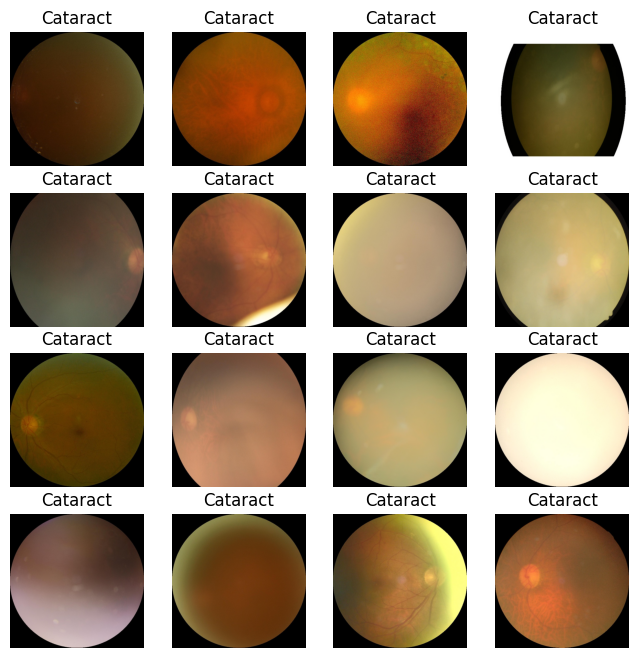

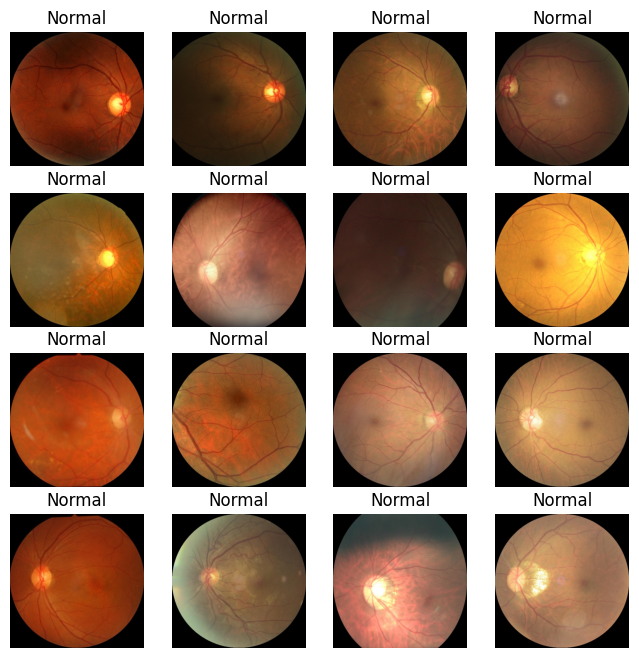

In [12]:
plot(cataract_dir, 'Cataract')
plot(normal_dir, 'Normal')

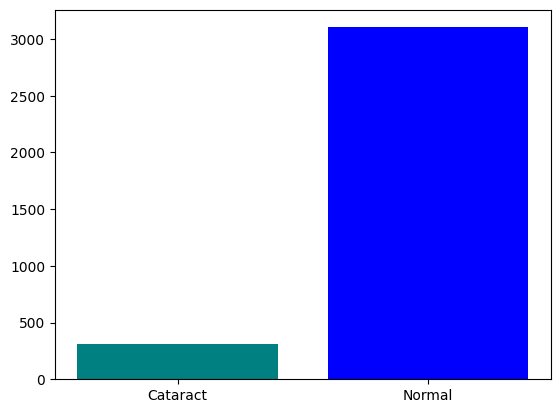

In [13]:
classes = ['Cataract', 'Normal']
counts = [len(os.listdir(cataract_dir)), len(os.listdir(normal_dir))]

plt.bar(classes, counts, color=['teal', 'blue'])
plt.show()

# 3. Augmentation

In [14]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf 
import scipy

# Set the path to the directory containing the original images
data_dir = 'labeled_images/cataract/'

# Create an ImageDataGenerator object to augment the images
datagen = ImageDataGenerator(
        rotation_range=20, # Randomly rotate images by up to 20 degrees
        horizontal_flip=True, # Randomly flip images horizontally
        fill_mode='constant' # Fill any empty pixels with the nearest value
)

# Loop through each image in the directory and apply the augmentation
for img_name in os.listdir(data_dir):
    img_path = os.path.join(data_dir, img_name)
    img = load_img(img_path) 
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    i = 0  
    for batch in datagen.flow(x, batch_size=1, save_to_dir=data_dir, save_prefix='aug', save_format='jpg'):
        i += 1
        if i > 10:
            break 

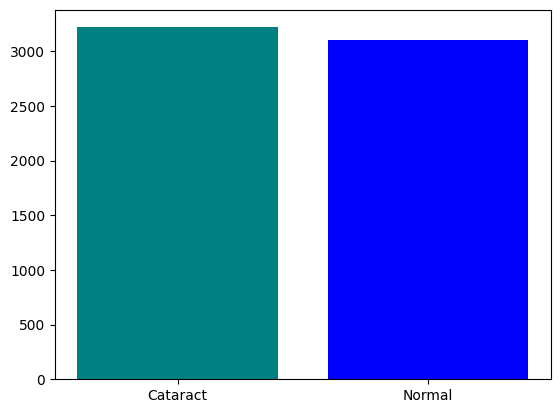

In [20]:
classes = ['Cataract', 'Normal']
counts = [len(os.listdir(cataract_dir)), len(os.listdir(normal_dir))]

plt.bar(classes, counts, color=['teal', 'blue'])
plt.show()

In [15]:
# LOAD THE DATASET
import pathlib
import tensorflow as tf

data_dir = "labeled_images/"
data_dir = pathlib.Path(data_dir)

In [17]:
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6322 files belonging to 2 classes.
Using 5058 files for training.


In [18]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6322 files belonging to 2 classes.
Using 1264 files for validation.


In [19]:
class_names = train_ds.class_names
print(class_names)

['cataract', 'normal']


# 4. Model Building

In [21]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [22]:
num_classes = len(class_names)
tf.random.set_seed(42)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.9),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['accuracy'])

In [24]:
# Stops the training if the validation accuracy doesn't improve for x consecutive epochs 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)

# Reduce the learning rate when the validation accuracy stagnates for x consecutive epochs 
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.5, 
                              patience = 5, 
                              min_delta = 0.001,
                              mode='auto',verbose=1)

In [27]:
### Plot History

def history(hist) : 
    # Plot the history for accuracy 
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # Plot the history for loss 
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

### Train

In [28]:
epochs=100
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[callback, reduce_lr]
)

Epoch 1/100
159/159 [==============================] - 99s 614ms/step - loss: 0.5186 - accuracy: 0.7285 - val_loss: 0.1894 - val_accuracy: 0.9280 - lr: 0.0010
Epoch 2/100
159/159 [==============================] - 95s 599ms/step - loss: 0.2145 - accuracy: 0.9233 - val_loss: 0.1999 - val_accuracy: 0.9328 - lr: 0.0010
Epoch 3/100
159/159 [==============================] - 93s 587ms/step - loss: 0.1740 - accuracy: 0.9320 - val_loss: 0.4845 - val_accuracy: 0.8703 - lr: 0.0010
Epoch 4/100
159/159 [==============================] - 93s 583ms/step - loss: 0.1978 - accuracy: 0.9292 - val_loss: 0.1254 - val_accuracy: 0.9470 - lr: 0.0010
Epoch 5/100
159/159 [==============================] - 94s 594ms/step - loss: 0.1417 - accuracy: 0.9417 - val_loss: 0.1268 - val_accuracy: 0.9502 - lr: 0.0010
Epoch 6/100
159/159 [==============================] - 91s 572ms/step - loss: 0.1350 - accuracy: 0.9446 - val_loss: 0.1028 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 7/100
159/159 [=========================

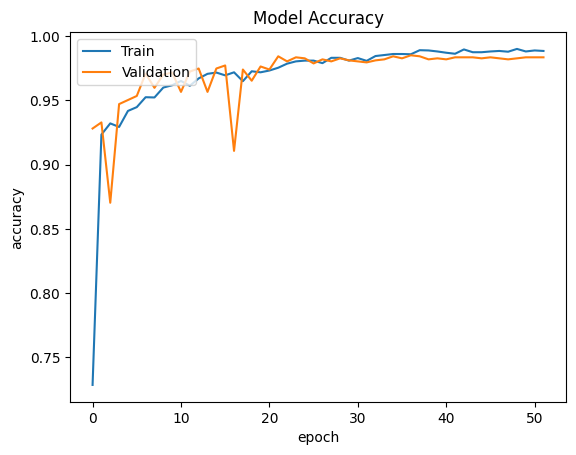

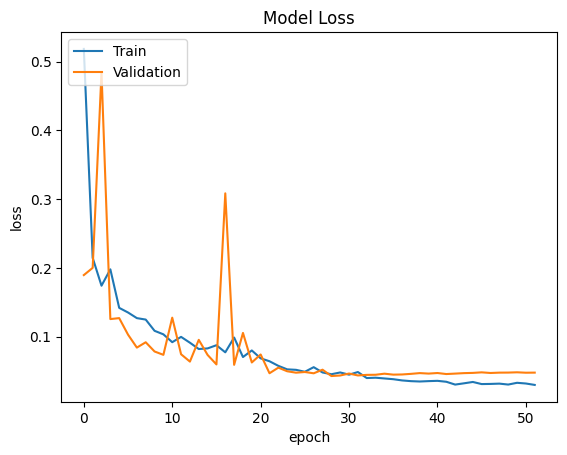

In [31]:
history(hist)

### Save Model And History

In [33]:
# Save Model And History
# model.save("catnet.h5")
model = keras.models.load_model("catnet.h5")

# import pickle
# with open('history', 'wb') as file_pi:
#     pickle.dump(hist.history, file_pi)

import pickle
with open('history', "rb") as file_pi:
    history = pickle.load(file_pi)

# 5. Evaluating Performance

In [34]:
# EVALUATE TRAINING ACCURACY
results = model.evaluate(train_ds)

159/159 [==============================] - 20s 126ms/step - loss: 0.0260 - accuracy: 0.9915


In [35]:
# EVALUATE VALIDATION ACCURACY
results = model.evaluate(val_ds)

40/40 [==============================] - 5s 123ms/step - loss: 0.0475 - accuracy: 0.9834


### Classification Report

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np 

prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in val_ds:
  prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(model.predict(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])

1/1 [==============================] - 0s 77ms/step


In [42]:
print(classification_report(true_classes, prediction_classes, target_names=class_names, digits=4))

              precision    recall  f1-score   support

    cataract     0.9888    0.9778    0.9833       632
      normal     0.9781    0.9889    0.9835       632

    accuracy                         0.9834      1264
   macro avg     0.9834    0.9834    0.9834      1264
weighted avg     0.9834    0.9834    0.9834      1264



### Confusion Matrix

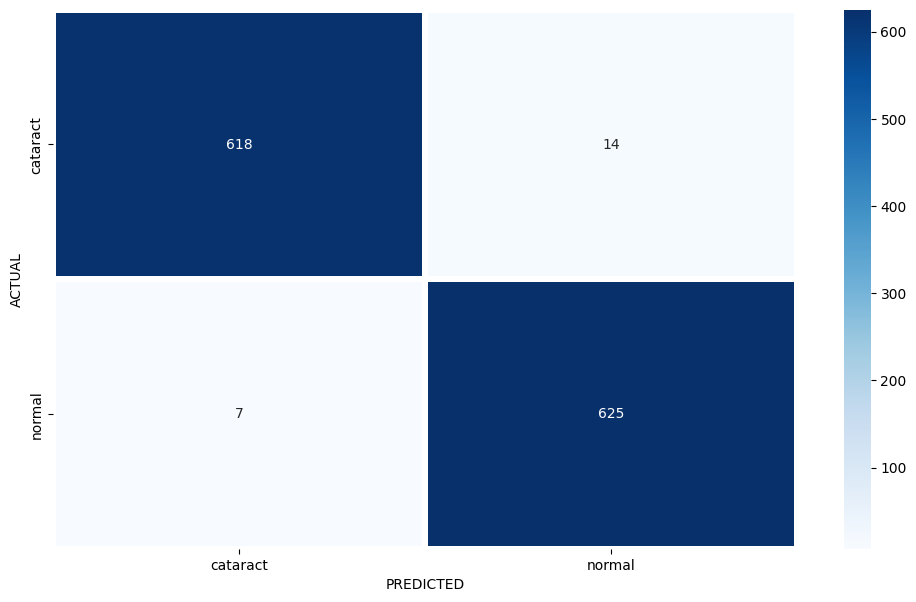

In [43]:
fig,ax=plt.subplots(1,1,figsize=(12,7))
cm = confusion_matrix(true_classes, prediction_classes)

sns.heatmap(cm,cmap="Blues", annot=True,xticklabels=class_names, yticklabels=class_names ,linewidths=3 ,fmt='g')
plt.xlabel("PREDICTED")
plt.ylabel("ACTUAL")
plt.show()

In [84]:
def predict(img_path):  
    img = tf.keras.utils.load_img(img_path, target_size=(256, 256))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = predictions[0]
    score = 100 * np.max(score)
    class_name = "{}".format(class_names[np.argmax(score)])
    res = {"Diagnosis": [class_name, score]}
    return res

In [85]:
predict('ODIR-5K\Testing Images\967_left.jpg')

1/1 [==============================] - 0s 25ms/step


{'Diagnosis': ['cataract', 100.0]}